- 概要：DGLのグラフ分類サンプルの写経。
- 目的：dglとdgl.batchの使い方を把握する
- わかったこと：dgl.batchを使うことでノード数、エッジ数の異なる複数のグラフを入力としたgraph classificationができる
- 応用したいこと：ノード数の異なる複数のグラフを入力に各ノードの属性を予測させるnode classification
- reference: https://docs.dgl.ai/en/0.6.x/tutorials/basics/4_batch.html

> To train neural networks efficiently, a common practice is to batch multiple samples together to form a mini-batch. Batching fixed-shaped tensor inputs is common. For example, batching two images of size 28 x 28 gives a tensor of shape 2 x 28 x 28. By contrast, batching graph inputs has two challenges:
> - Graphs are sparse.
> -Graphs can have various length. For example, number of nodes and edges.
>
> To address this, DGL provides a `dgl.batch()` API. It leverages the idea that a batch of graphs can be viewed as a large graph that has many disjointed connected components. Below is a visualization that gives the general idea.

# Install DGL

In [1]:
!conda install -q -y -c dglteam dgl

Solving environment: ...working... done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - dgl


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    dgl-0.7.2                  |           py37_0         5.1 MB  dglteam
    ------------------------------------------------------------
                                           Total:         5.1 MB

The following NEW packages will be INSTALLED:

  dgl                dglteam/linux-64::dgl-0.7.2-py37_0


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


# Import

In [2]:
import dgl
import torch
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx

from dgl.nn.pytorch import GraphConv

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from dgl.dataloading import GraphDataLoader

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


Using backend: pytorch


# Load toy dataset
> In this tutorial, you learn how to perform batched graph classification with DGL. The example task objective is to classify eight types of topologies shown here.
> 
> https://data.dgl.ai/tutorial/batch/dataset_overview.png
> 
> Implement a synthetic dataset data.MiniGCDataset in DGL. The dataset has eight different types of graphs and each class has the same number of graph samples.

In [3]:
# A dataset with 80 samples, each graph is
# of size [10, 20]
dataset = MiniGCDataset(80, 10, 20)

## Quick look at the Dataset

In [4]:
dataset

In [5]:
# dir(dataset)

`dgl.data`のインスタンスには配列っぽいアクセスができる様子

In [6]:
len(dataset)

80

このdatasetの場合、(グラフ クラス)のtupleが入っている

In [7]:
dataset[0]

(Graph(num_nodes=15, num_edges=45,
       ndata_schemes={}
       edata_schemes={}),
 tensor(0))

０番目のグラフを表示してみる

(Graph(num_nodes=15, num_edges=45,
      ndata_schemes={}
      edata_schemes={}), tensor(0))


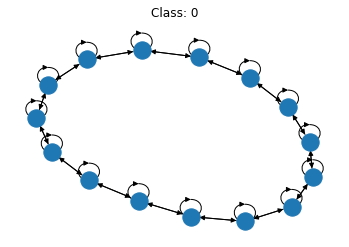

In [8]:
def plot_data(n):
    print(dataset[n])
    graph, label = dataset[n]
    fig, ax = plt.subplots()
    nx.draw(graph.to_networkx(), ax=ax)
    ax.set_title('Class: {:d}'.format(label))
    plt.show()
    
plot_data(0)

(Graph(num_nodes=17, num_edges=49,
      ndata_schemes={}
      edata_schemes={}), tensor(1))


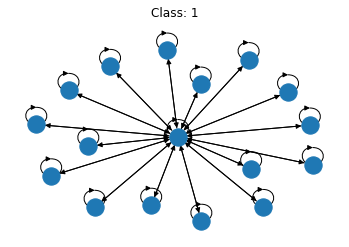

In [9]:
#10番目
plot_data(10)

(Graph(num_nodes=15, num_edges=71,
      ndata_schemes={}
      edata_schemes={}), tensor(2))


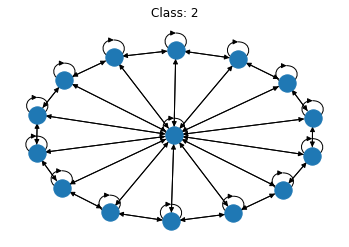

In [10]:
#20番目
plot_data(20)

## わかったこと
- このデータは8種類の形状が異なる80個のグラフを含んでいるデータ
- このタスクはそれぞれのグラフの種類を予測させるタスク
- 各グラフはノード数、エッジ数が異なっているグラフ
- おそらくdataset[9:0]はclass=0, [19:10]はclass=1のデータという感じになっている->要shaffle

# Data loader

In [11]:
# Create training and test sets.
trainset = MiniGCDataset(320, 10, 20)
testset = MiniGCDataset(80, 10, 20)

In [12]:
# Use DGL's GraphDataLoader. It by default handles the
# graph batching operation for every mini-batch.
data_loader = GraphDataLoader(trainset, batch_size=32, shuffle=True)

# Model

In [13]:
class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.conv1 = GraphConv(in_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # Use node degree as the initial node feature. For undirected graphs, the in-degree
        # is the same as the out_degree.
        h = g.in_degrees().view(-1, 1).float()
        # Perform graph convolution and activation function.
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
        g.ndata['h'] = h
        # Calculate graph representation by averaging all the node representations.
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)

In [14]:
# Create model
model = Classifier(1, 256, trainset.num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

Classifier(
  (conv1): GraphConv(in=1, out=256, normalization=both, activation=None)
  (conv2): GraphConv(in=256, out=256, normalization=both, activation=None)
  (classify): Linear(in_features=256, out_features=8, bias=True)
)

# Train

In [15]:
epoch_losses = []
for epoch in range(80):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        prediction = model(bg)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

Epoch 0, loss 2.0245
Epoch 1, loss 1.9756
Epoch 2, loss 1.9618
Epoch 3, loss 1.9519
Epoch 4, loss 1.9437
Epoch 5, loss 1.9430
Epoch 6, loss 1.9179
Epoch 7, loss 1.9039
Epoch 8, loss 1.8852
Epoch 9, loss 1.8584
Epoch 10, loss 1.8252
Epoch 11, loss 1.7851
Epoch 12, loss 1.7430
Epoch 13, loss 1.6978
Epoch 14, loss 1.6489
Epoch 15, loss 1.5919
Epoch 16, loss 1.5332
Epoch 17, loss 1.4748
Epoch 18, loss 1.4120
Epoch 19, loss 1.3475
Epoch 20, loss 1.2924
Epoch 21, loss 1.2420
Epoch 22, loss 1.2102
Epoch 23, loss 1.1610
Epoch 24, loss 1.1343
Epoch 25, loss 1.0928
Epoch 26, loss 1.0424
Epoch 27, loss 1.0107
Epoch 28, loss 0.9939
Epoch 29, loss 0.9978
Epoch 30, loss 0.9606
Epoch 31, loss 0.9382
Epoch 32, loss 0.9457
Epoch 33, loss 0.9227
Epoch 34, loss 0.9074
Epoch 35, loss 0.8928
Epoch 36, loss 0.8815
Epoch 37, loss 0.8749
Epoch 38, loss 0.8768
Epoch 39, loss 0.8771
Epoch 40, loss 0.8621
Epoch 41, loss 0.8454
Epoch 42, loss 0.8569
Epoch 43, loss 0.8232
Epoch 44, loss 0.8279
Epoch 45, loss 0.823

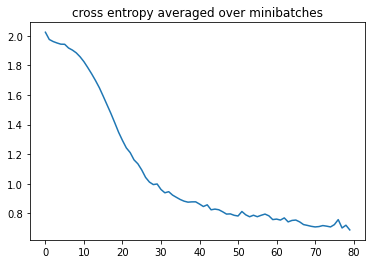

In [16]:
plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

# Test

In [17]:
# modelを推論モードに切り替え
model.eval()

Classifier(
  (conv1): GraphConv(in=1, out=256, normalization=both, activation=None)
  (conv2): GraphConv(in=256, out=256, normalization=both, activation=None)
  (classify): Linear(in_features=256, out_features=8, bias=True)
)

In [18]:
# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))

In [19]:
# test_Xは学習には使っていないテスト用のグラフが80個入っているリスト
test_X

[Graph(num_nodes=15, num_edges=45,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=10, num_edges=30,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=13, num_edges=39,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=13, num_edges=39,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=17, num_edges=51,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=19, num_edges=57,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=13, num_edges=39,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=15, num_edges=45,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=12, num_edges=36,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=14, num_edges=42,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=17, num_edges=49,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=16, num_edges=46,
       ndata_schemes={}
      

In [20]:
# test_Yは正解クラスが80個入っているリスト
test_Y

[tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(2),
 tensor(2),
 tensor(2),
 tensor(2),
 tensor(2),
 tensor(2),
 tensor(2),
 tensor(2),
 tensor(2),
 tensor(2),
 tensor(3),
 tensor(3),
 tensor(3),
 tensor(3),
 tensor(3),
 tensor(3),
 tensor(3),
 tensor(3),
 tensor(3),
 tensor(3),
 tensor(4),
 tensor(4),
 tensor(4),
 tensor(4),
 tensor(4),
 tensor(4),
 tensor(4),
 tensor(4),
 tensor(4),
 tensor(4),
 tensor(5),
 tensor(5),
 tensor(5),
 tensor(5),
 tensor(5),
 tensor(5),
 tensor(5),
 tensor(5),
 tensor(5),
 tensor(5),
 tensor(6),
 tensor(6),
 tensor(6),
 tensor(6),
 tensor(6),
 tensor(6),
 tensor(6),
 tensor(6),
 tensor(6),
 tensor(6),
 tensor(7),
 tensor(7),
 tensor(7),
 tensor(7),
 tensor(7),
 tensor(7),
 tensor(7),
 tensor(7),
 tensor(7),
 tensor(7)]

In [21]:
# テスト用のグラフのリストを`dgl.batch`でまとめる
test_bg = dgl.batch(test_X)

In [22]:
# テスト用の正解が入っている要素数=80のリストをtorch.Tensor;size=(80,1)に変換する
test_Y = torch.tensor(test_Y).float().view(-1, 1)
test_Y.shape

torch.Size([80, 1])

In [23]:
# 推論させるにはモデルに`dgl.batch`でまとめたグラフを入力する
pred = model(test_bg)

In [24]:
# 各グラフ x 8クラスの予測値が返る
pred.shape

torch.Size([80, 8])

In [25]:
# softmaxで各グラフ x 8クラスの確率分布に変換
probs_Y = torch.softmax(pred, 1)
probs_Y.shape

torch.Size([80, 8])

In [26]:
# ここわかんない
sampled_Y = torch.multinomial(probs_Y, 1)
# sampled_Y

In [27]:
# なぜtorch.argmaxじゃないんだろう
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
# argmax_Y

In [28]:
print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100))
print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
    (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))

Accuracy of sampled predictions on the test set: 55.0000%
Accuracy of argmax predictions on the test set: 70.000000%
